In [105]:
import pandas as pd
import numpy as np
import gwaslab as gl
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/clu/git/3D_cardiac_GWAS/src')
from bullseye import bullseye_plot, get_cmap_center
import matplotlib as mpl
# sns style
sns.set_style("white")
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 11})

consequences = pd.read_csv('ensembl_consequence.list', sep='\t')
consequences['IMPACT'] = pd.Categorical(consequences['IMPACT'], categories=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'], ordered=True)


# Burden

In [59]:
working_dir = '/Volumes/acasis/cardiac/48K/burden_aha_t64/'

input_regenie = '/Volumes/acasis/cardiac/48K/burden_aha_t64/burden_40kahat64_sexagebmibsa_WT_t16_merged.regenie'
# input_strain_regenie = '/Volumes/acasis/cardiac/48K/burden_aha_t64/burden_40kahat64_sexagebmibsa2bp_E_t32_merged.regenie'

# read regional association results
wt = pd.read_csv(input_regenie, sep='\t')

wt = wt[wt.ID.str.startswith('ALPK3')]
wt['label'] = ['AHA_'+x.split('AHA_')[1].split('_')[0] for x in wt.EXTRA]
wt.drop(columns=['EXTRA'], inplace=True)

for trait in ['WT_Global', 'WT_Max_Global', 'LVM']:
    burdensummstats = pd.read_csv(f'/Volumes/acasis/cardiac/48K/burden_aha_t64/Burden_regenie_AHA_64_merge/AHA_40k_2bpt14__{trait}_chrmerged.regenie.gz.gz', sep='\t')
    burdensummstats = burdensummstats[burdensummstats.ID.str.startswith('ALPK3')]
    burdensummstats = burdensummstats[burdensummstats.ALLELE1.str.startswith('M1')]
    burdensummstats['label'] = trait
    wt = pd.concat([wt, burdensummstats])


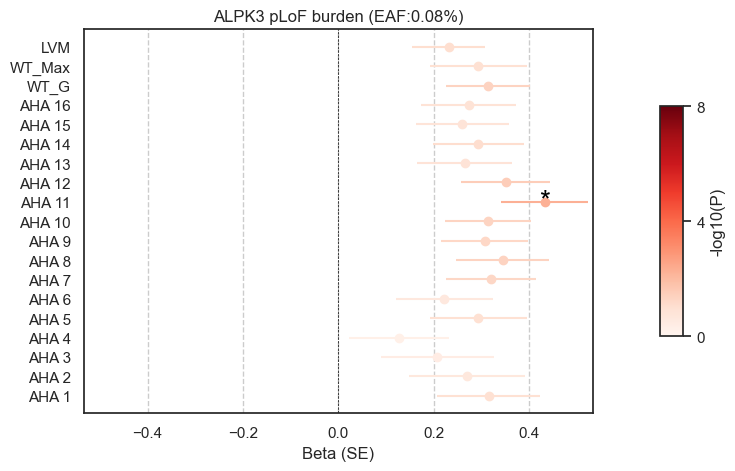

In [110]:
genename = 'ALPK3'
sel_traits = [f'AHA_{i}' for i in range(1,17)] + ['WT_Global', 'WT_Max_Global', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['WT_G', 'WT_Max', 'LVM']
lookup = wt[(wt.TEST=='ADD') & (wt.ALLELE1.str.startswith('M1.all'))]

# def forrestplot_gene(genename, lookup, sel_traits_names):
# forest plot of beta values
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 16})
# build a dataframe with the selected variant as row and beta /P for each label as column
sel_variant = pd.DataFrame(index=[genename])
for _, row in lookup.iterrows():
    sel_variant = sel_variant.assign(
        **{f'{row.label}_BETA': [row.BETA], f'{row.label}_SE': [row.SE], f'{row.label}_MLOG10P': [row.LOG10P]}
    )
sel_variant = sel_variant.assign(A1FREQ=[lookup.A1FREQ.iloc[0]])
sel_variant = sel_variant.iloc[0]
betamax = abs(sel_variant[[f'{i}_BETA' for i in sel_traits]].values.flatten()).max()+0.1
        
# forest plot each beta and se as error bar for the selected variant by sel_traits
for i, trait in enumerate(sel_traits):
    # color by LOG10P
    ax.errorbar(sel_variant[f'{trait}_BETA'], i, xerr=sel_variant[f'{trait}_SE'], fmt='o', label=sel_traits_names[i], color=plt.cm.Reds(sel_variant[f'{trait}_MLOG10P']/20))
    # if LOG10P > -np.log10(5e-8/16) then annotate *
    if sel_variant[f'{trait}_MLOG10P'] > -np.log10(0.05/3250):
        ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
    # elif sel_variant[f'{trait}_MLOG10P'] > -np.log10(0.01):
    #     ax.annotate('*', (sel_variant[f'{trait}_BETA'], i), fontsize=20, color='black', ha='center', va='center')
# add colorbar
cmap = mpl.cm.ScalarMappable(cmap='Reds', norm=mpl.colors.Normalize(vmin=0, vmax=8))
cbar = plt.colorbar(cmap, ax=ax, orientation='vertical', 
                    pad=0.1, aspect=10, shrink=0.6, 
                    label='-log10(P)', ticks=[0, 4, 8])
_ = ax.set_yticks(range(len(sel_traits)))
_ = ax.set_yticklabels(sel_traits_names)
ax.set_xlim(-betamax, betamax)
ax.set_xlabel('Beta (SE)')
ax.grid(axis='x', linestyle='--')
# vertical line at 0
ax.axvline(0, color='black', lw=0.5, linestyle='--')
# set title
ax.set_title(f'{genename} pLoF burden (EAF:{sel_variant.A1FREQ*100:.2f}%)')
plt.tight_layout()
# save
plt.savefig(f'/Users/clu/git/3D_cardiac_GWAS/0SORTED/Figures/Genes/burdenM1_{genename}_WT_forestplotBeta.pdf')

# forrestplot_gene(genename, lookup, sel_traits_names)

In [46]:
# lookup = wt[(wt.TEST=='ADD-SKAT') & (wt.ALLELE1.str.startswith('M1.all')) & (wt.EXTRA.str.contains('WT_AHA'))]
lookup = wt[(wt.TEST=='ADD') & (wt.ALLELE1.str.startswith('M1.all')) & (wt.EXTRA.str.contains('WT_AHA'))]


(16, 14)

# ALPK3 high impact variants from participant explorer

In [21]:
pp = pd.read_csv('ALPK3_Participant_table.csv')
phenos = pd.read_csv('../Run_Data/phenotypes_48k_99CMR_13other.csv')
print('pp', pp.shape[0], 'pp in phenos', pp[pp['Participant ID'].isin(phenos['eid_40616'])].shape[0])

pp 158 pp in phenos 132


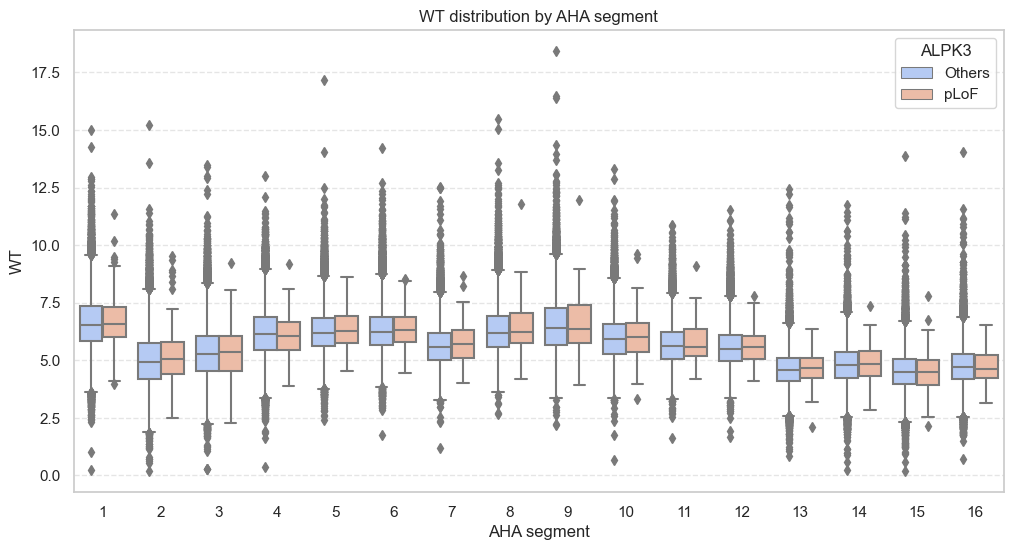

In [33]:
# plot phenos distribution for participants in and not in the ALPK3  for WT_AHA_1-16
phenosplot = phenos[phenos[['eid_40616'] + [f'WT_AHA_{x}' for x in range(1,17)]].notnull()]
phenosplot = phenosplot.assign(ALPK3 = [1 if x in pp['Participant ID'].values else 0 for x in phenosplot['eid_40616']])

plot_sample = pd.melt(phenosplot, id_vars=['ALPK3'], value_vars=[f'WT_AHA_{x}' for x in range(1, 17)], value_name='value')

plot_sample = plot_sample.assign(AHA=plot_sample.variable.str.split('_').str[-1])

plot_sample.loc[plot_sample.ALPK3==1, 'ALPK3'] = 'pLoF'
plot_sample.loc[plot_sample.ALPK3==0, 'ALPK3'] = 'Others'

# side by side boxplot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='AHA', y='value', data=plot_sample, hue='ALPK3', ax=ax, palette='coolwarm')
ax.set_title('WT distribution by AHA segment')
ax.set_xlabel('AHA segment')
ax.set_ylabel('WT')
# grid lines
ax.grid(axis='y', linestyle='--', alpha=0.5)
# legend remove
# ax.legend().remove()

# Genomics variants data

In [ ]:
# VEP variants in ALPK3
ukbb_exome_folder = '/Volumes/acasis/data/ukbb/exomes/'

# EXclusion list
with open(f'{ukbb_exome_folder}/90pct10dp_qc_variants.out', 'r') as f:
    excl_90pct10dp = set([x.strip() for x in f.readlines()])

# Burden variants set
burden_variants = set()
for i in range(1, 23):
    with open(f'{ukbb_exome_folder}/OQFE_bim_variants_helper_geneset_excl_90pct10dp/{i}_variants_chr.list', 'r') as f:
        burden_variants.update([x.strip() for x in f.readlines()])

# Variant level association with ALPK3
def get_mysumstats(gwaspath):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # Exclude 90pct10dp failed variants
    mysumstats.data = mysumstats.data[~mysumstats.data['SNPID'].isin(excl_90pct10dp)]
    return mysumstats
# which_variants_tested SNPID to variant ID: add chr to SNPID and change 23 to X, 24 to Y
which_variants_tested = get_mysumstats('/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_WT_AHA_1_chrmerged.regenie.gz').data
which_variants_tested['variant'] = 'chr' + which_variants_tested['SNPID']
which_variants_tested['variant'] = which_variants_tested['variant'].str.replace('chr23:', 'chrX:').str.replace('chr24:', 'chrY:')


## ALPK3

In [4]:
genename = 'ALPK3'
chrom = 15
vep_file = f'/Volumes/acasis/data/ukbb/exomes/OQFE_bim_variants_vep/vep-ukb23158_c{chrom}_b0_v1.bim_variants_transcript_conseq.tsv'
vep_data = pd.read_csv(vep_file, sep='\t')
vep_data = vep_data[vep_data['gene_symbol']==genename]
variants_set = set(vep_data['variant'])
print(f'Number of variants in {genename}: {len(variants_set)}')

vep_data=vep_data.drop(columns=['locus.contig','locus.position','gene_id','alleles'])


/var/folders/6y/1p43n3zs7zn39bj64mc3fmmc0000gn/T/ipykernel_98919/838685051.py:4: DtypeWarning: Columns (4,11,12,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  vep_data = pd.read_csv(vep_file, sep='\t')


Number of variants in ALPK3: 3150


In [85]:
# Burden variants in ALPK3
burden_variants_alpk3 = burden_variants.intersection(variants_set)
print('Burden variants in ALPK3:', len(burden_variants_alpk3))

# Variants tested in ALPK3
ALPK3_ExomeGWAS_variants = which_variants_tested[which_variants_tested['variant'].isin(variants_set)]
ALPK3_ExomeGWAS_variants = ALPK3_ExomeGWAS_variants[['SNPID','CHR','POS', 'EA', 'NEA','EAF','variant']]
print('Number of variants tested:', which_variants_tested.shape[0])

# # make sure 
# print(vep_data[vep_data['variant'].isin(burden_variants_alpk3)].shape[0])
# vep_data[vep_data['variant'].isin(burden_variants_alpk3)].consequence_terms.value_counts()

Burden variants in ALPK3: 1503
Number of variants tested: 142


In [80]:
# READ common variants summary stats: ALPK3_ExomeGWAS_variants to be used for filtering, exome_spatial_WT is the output
filter_snpids = set(ALPK3_ExomeGWAS_variants.SNPID.tolist())

# read the beta and p values for the hits for WT AHA segments
def filter_summstats(gwaspath, filtersnps):
    mysumstats = gl.Sumstats(gwaspath, fmt="regenie", verbose=False)
    # Exclude 90pct10dp failed variants
    mysumstats.data = mysumstats.data[mysumstats.data['SNPID'].isin(filtersnps)]
    return mysumstats.data

# filter_snpids = set(hits_all[(hits_all.trait=='WT')].SNPID.tolist())
sel_traits = [f'WT_AHA_{i}' for i in range(1,17)] + ['WT_Global', 'WT_Max_Global', 'LVM']
sel_traits_names = [f'AHA {i}' for i in range(1,17)] + ['WT_G', 'WT_Max', 'LVM']

exome_spatial_WT = pd.DataFrame()
for it, trait in enumerate(sel_traits):
    print(trait, exome_spatial_WT.shape)
    eachone = filter_summstats(f'/Volumes/acasis/cardiac/48K/exomeGWAS_aha_t64/AHA_exomeGWAS_{trait}_chrmerged.regenie.gz', filter_snpids)
    eachone = eachone[[
        'SNPID', 'BETA', 'MLOG10P', 'SE'
    ]].rename(columns={
        'BETA': f'{trait}_BETA',
        'MLOG10P': f'{trait}_MLOG10P',
        'SE': f'{trait}_SE'
    })
    if it == 0:
        exome_spatial_WT = eachone
    else:
        exome_spatial_WT = pd.merge(exome_spatial_WT, eachone, on='SNPID', how='left')
    

WT_AHA_1 (0, 0)
Sun Jun  9 18:17:40 2024 GWASLab version 3.4.21 https://cloufield.github.io/gwaslab/
Sun Jun  9 18:17:40 2024 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Sun Jun  9 18:17:40 2024   - format_name  : regenie
Sun Jun  9 18:17:40 2024   - format_source_1  : https://rgcgithub.github.io/regenie/
Sun Jun  9 18:17:40 2024   - format_source_2  : https://github.com/rgcgithub/regenie/blob/master/example/test_bin_out_firth_Y1.regenie
Sun Jun  9 18:17:40 2024   - format_version  : 20220726
Sun Jun  9 18:17:40 2024   - format_cite_name  : REGENIE
Sun Jun  9 18:17:40 2024   - format_separator  : \s 
Sun Jun  9 18:17:40 2024   - format_na  : NA
Sun Jun  9 18:17:40 2024   - format_col_order  : CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P
Sun Jun  9 18:17:40 2024   - last_check_date  :  20230501
Sun Jun  9 18:17:40 2024  -regenie to gwaslab format dictionary:
Sun Jun  9 18:17:40 2024   - regenie keys: ID,CHROM,GENPOS,ALLELE0,ALLELE1,A1FREQ,

In [86]:
# get VEP data for the exomeGWAS variants
ALPK3_ExomeGWAS_variants = ALPK3_ExomeGWAS_variants.merge(vep_data[['variant', 'amino_acids', 'biotype', 'consequence_terms',
       'exon', 'gene_symbol', 'lof', 'lof_flags', 'lof_filter', 'lof_info',
       'minimised', 'polyphen_prediction', 'polyphen_score', 'protein_id',
       'sift_prediction', 'sift_score']], on='variant', how='left')

# Understand consequence terms and impact
# keep the first consequence term
ALPK3_ExomeGWAS_variants = ALPK3_ExomeGWAS_variants.assign(consequence = ALPK3_ExomeGWAS_variants['consequence_terms'].apply(lambda x: x.split("'")[1]))
# apply impact by consequence
ALPK3_ExomeGWAS_variants = ALPK3_ExomeGWAS_variants.merge(consequences, left_on='consequence', right_on='consequence_term', how='left')

In [111]:
# plot the heatmap
def plot_heatmap_beta(highimpact, savepath=None, figsize=(10,12)):
    fig, axes = plt.subplots(1,1,figsize=figsize)
    # font Arial
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams.update({'font.size': 11})
    # cmap is blue to red for beta values (middle 0, vmax = abs(beta)), and Reds for log10p values
    betamax = 1
    sns.heatmap(highimpact[[f'{i}_BETA' for i in sel_traits]], center=0, ax=axes, cmap='RdBu_r', vmax=betamax, vmin=-betamax)
    # add text, if LOG10P < 5e-8/16 then add **, if LOG10P < 5e-8 then add *
    for i, trait in enumerate(sel_traits):
        for j in range(highimpact.shape[0]):
            if highimpact.loc[j, f'{trait}_MLOG10P'] > -np.log10(5e-8/16):
                axes.text(i+0.5, j+0.5, '**', ha='center', va='center', fontsize=10, color='black')
            if highimpact.loc[j, f'{trait}_MLOG10P'] > -np.log10(5e-8):
                axes.text(i+0.5, j+0.5, '**', ha='center', va='center', fontsize=10, color='black')

    # add colorbar
    cbar = axes.collections[0].colorbar
    cbar.set_label('Beta')
    # cbar = plt.colorbar(cmap='RdBu_r', ax=ax, orientation='vertical', 
    #                         pad=0.1, aspect=10, shrink=0.6, 
    #                         label='Beta')
    # # shrink the colorbar
    cbar.ax.set_position([0.9, 0.2, 0.03, 0.4])
    # set yticks to gene_symbol_new
    axes.set_yticks(np.arange(highimpact.shape[0])+0.5)
    axes.set_yticklabels(highimpact['label'], rotation=0, ha='right')

    # add xticks to trait names
    axes.set_xticks(np.arange(len(sel_traits))+0.5)
    axes.set_xticklabels(sel_traits_names, rotation=45, ha='right')

    # hlines
    for i in range(highimpact.shape[0]):
        axes.axhline(i, color='white', lw=0.5)
    for i in range(len(sel_traits)):
        axes.axvline(i, color='white', lw=0.5)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)


Number of high impact variants: 64 Number of unique variants: 63
Number of high impact unique variants: 63


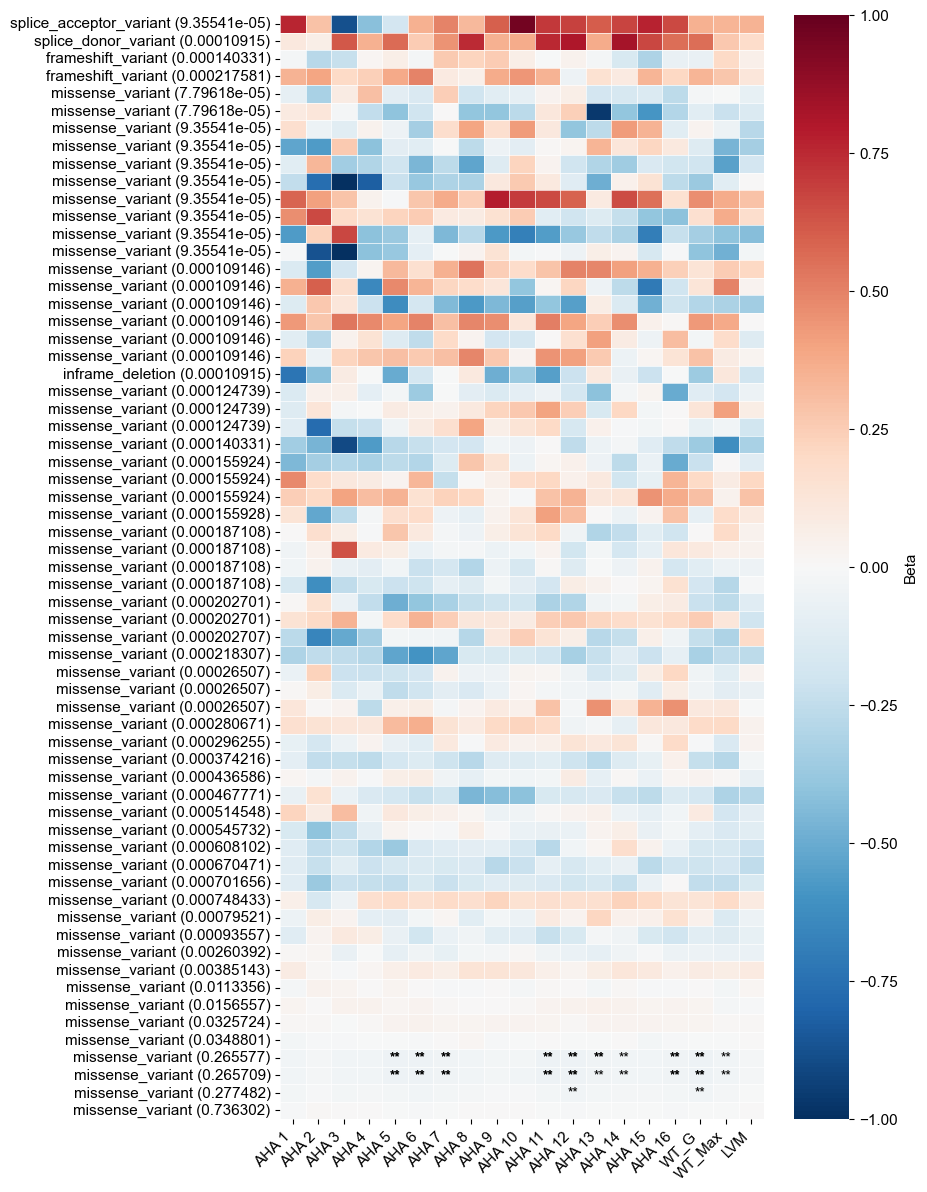

In [123]:
# high impact variants
highimpact = ALPK3_ExomeGWAS_variants[ALPK3_ExomeGWAS_variants.IMPACT.isin(['HIGH', 'MODERATE'])][[
    'SNPID','EAF','consequence','IMPACT','lof','lof_info', 'polyphen_prediction','sift_prediction'
]].sort_values('IMPACT')
print('Number of high impact variants:', highimpact.shape[0], 'Number of unique variants:', highimpact.SNPID.nunique())

highimpact = highimpact.assign(label = [f'{i} ({j})' for i,j in zip(highimpact['consequence'], highimpact['EAF'])])

# heatmap for high impact variants
highimpact = highimpact.merge(exome_spatial_WT, on='SNPID', how='left')

# sort
highimpact = highimpact.sort_values(['IMPACT', 'EAF'])
# drop duplicates
highimpact = highimpact.drop_duplicates('SNPID')
print('Number of high impact unique variants:', highimpact.shape[0])

highimpact.reset_index(drop=True, inplace=True)

plot_heatmap_beta(highimpact, savepath='ALPK3_highimpact_variants_heatmap.png')

# In burden

In [121]:
print('In burden_variants_alpk3 but not in ALPK3_ExomeGWAS_variants:', len(burden_variants_alpk3 - set(ALPK3_ExomeGWAS_variants.variant.tolist())))
print('In burden and ALPK3_ExomeGWAS_variants:', len(burden_variants_alpk3.intersection(set(ALPK3_ExomeGWAS_variants.variant.tolist()))))

# heatmap for burden and ALPK3_ExomeGWAS_variants
burden_variants_alpk3_exome = ALPK3_ExomeGWAS_variants[ALPK3_ExomeGWAS_variants['variant'].isin(burden_variants_alpk3)]
burden_variants_alpk3_exome = burden_variants_alpk3_exome.assign(
    label = [f'{i} ({j})' for i,j in zip(burden_variants_alpk3_exome['consequence'], burden_variants_alpk3_exome['EAF'])])

burden_variants_alpk3_exome = burden_variants_alpk3_exome.merge(exome_spatial_WT, on='SNPID', how='left').reset_index(drop=True)
burden_variants_alpk3_exome['IMPACT'] = pd.Categorical(burden_variants_alpk3_exome['IMPACT'], categories=['LOW', 'MODIFIER', 'MODERATE', 'HIGH'])


In burden_variants_alpk3 but not in ALPK3_ExomeGWAS_variants: 1429
In burden and ALPK3_ExomeGWAS_variants: 74


Number of burden variants in ALPK3: 74


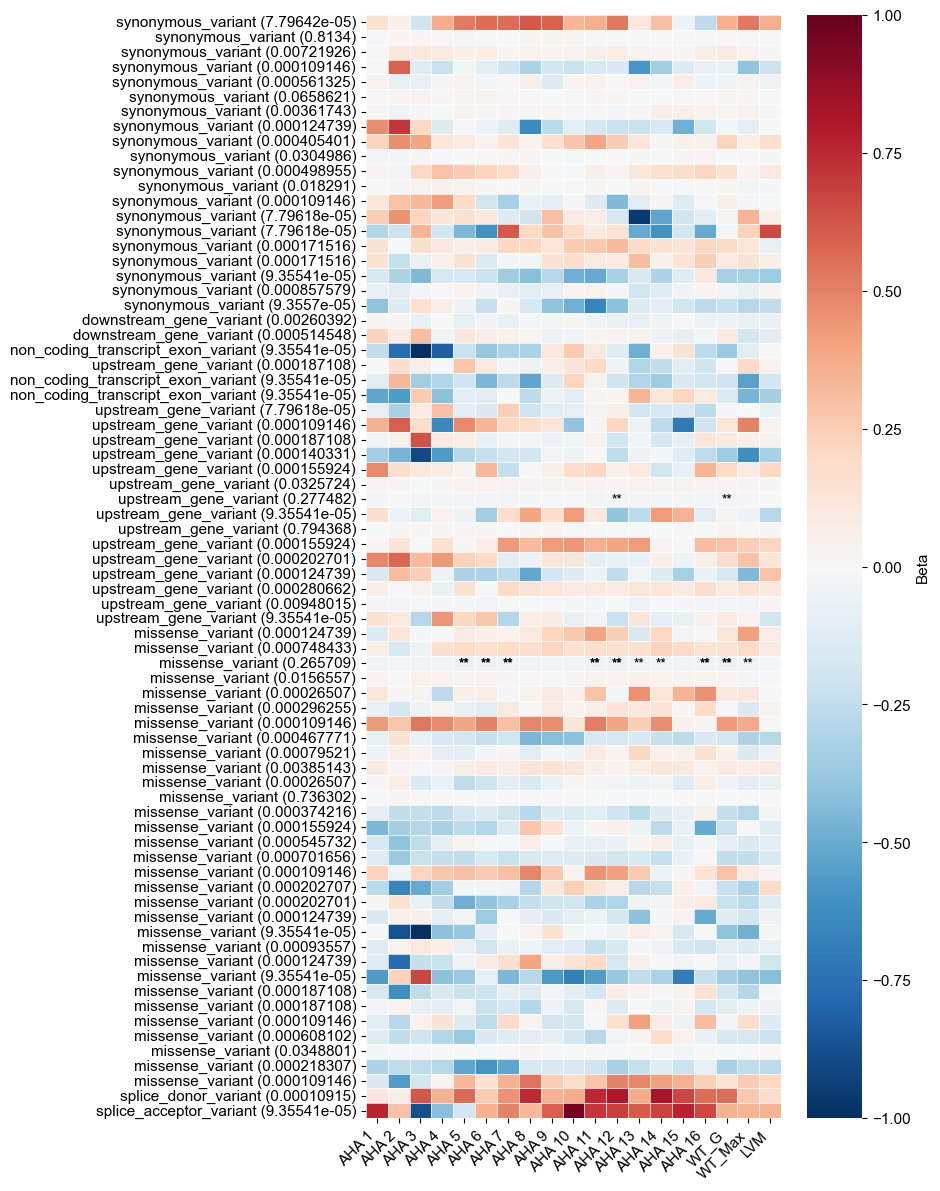

In [122]:
burden_variants_alpk3_exome.sort_values('IMPACT', inplace=True)
# drop duplicates
burden_variants_alpk3_exome = burden_variants_alpk3_exome.drop_duplicates(subset=['SNPID'])
print('Number of burden variants in ALPK3:', burden_variants_alpk3_exome.shape[0])

burden_variants_alpk3_exome = burden_variants_alpk3_exome.reset_index(drop=True)

# plot the heatmap
plot_heatmap_beta(burden_variants_alpk3_exome, savepath='ALPK3_burden_variants_heatmap.png')

In [ ]:
# ALPK3 2BP
path = '/Volumes/acasis/cardiac/48K/lovo/lovo_40kahat64_sexagebmibsa2bp_ALPK3_M1_regional_WT_AHA_11.regenie'
lovo = pd.read_csv(path, delim_whitespace=True, header=1)

lovo = lovo.assign(SNPID = lovo['ID'].apply(lambda x: x.split('_')[-1]))
lovo = lovo.assign(variant = 'chr' + lovo['SNPID'])

# add vep
lovo = lovo.merge(vep_data[['variant', 'amino_acids', 'biotype', 'consequence_terms',
       'exon', 'gene_symbol', 'lof', 'lof_flags', 'lof_filter', 'lof_info',
       'minimised', 'polyphen_prediction', 'polyphen_score', 'protein_id',
       'sift_prediction', 'sift_score']], on='variant', how='left')

print('lovo', lovo.shape[0], 'lovo with consequence:', lovo[lovo['consequence_terms'].notnull()].shape[0])

lovo[['ID', 'A1FREQ', 'BETA', 'SE', 'LOG10P','N', 'TEST','consequence_terms']].sort_values('LOG10P', ascending=False)

In [120]:
# add impact
lovo_impact = lovo[lovo['consequence_terms'].notnull()]
lovo_impact = lovo_impact.assign(consequence = lovo_impact['consequence_terms'].apply(lambda x: x.split("'")[1]))
lovo_impact = lovo_impact.merge(consequences, left_on='consequence', right_on='consequence_term', how='left')

# sort by IMPACT and drop duplicates
lovo_impact = lovo_impact.sort_values('IMPACT')
lovo_impact = lovo_impact.drop_duplicates('variant')
print('Number of unique variants:', lovo_impact.shape[0])

lovo_impact[['variant', 'A1FREQ', 'BETA', 'SE', 'LOG10P', 'consequence','IMPACT' ]].sort_values('A1FREQ')

Number of unique variants: 15


,variant,A1FREQ,BETA,SE,LOG10P,consequence,IMPACT
0,chr15:84817038:C:A,0.000499,0.646947,0.119469,7.21310,upstream_gene_variant,MODIFIER
14,chr15:84863641:G:GT,0.000670,0.401262,0.103072,4.00435,splice_donor_variant,HIGH
5,chr15:84856391:G:A,0.000686,0.415872,0.101901,4.34857,splice_acceptor_variant,HIGH
8,chr15:84857913:C:T,0.000717,0.432613,0.099657,4.84827,stop_gained,HIGH
17,chr15:84867361:C:T,0.000717,0.435484,0.099652,4.90579,stop_gained,HIGH
4,chr15:84840352:AG:A,0.000748,0.437429,0.097564,5.13414,frameshift_variant,HIGH
11,chr15:84862739:C:T,0.000764,0.458292,0.096562,5.68320,stop_gained,HIGH
19,chr15:84868301:C:T,0.000764,0.483703,0.096559,6.26280,stop_gained,HIGH
9,chr15:84862718:C:T,0.000764,0.455665,0.096563,5.62492,stop_gained,HIGH
15,chr15:84864440:A:T,0.000764,0.449134,0.096560,5.48173,splice_acceptor_variant,HIGH
